# **Vocal Biomarker Estimator for Parkinson’s Disease**

 **Notebook 2 of 2: Disease Severity Regression using LSTM-CNN Ensemble**
### AAI-590 Capstone Project

**Author:** Arifa Kokab  
**Group:** 11 (Solo)  
**Program:** M.Sc. Applied Artificial Intelligence  
**School:** University of San Diego - Shiley-Marcos School of Engineering  

*Launched under CarePath AI Foundation (Non-Profit)*

#**INTRODUCTION**

This notebook is the second part of the Vocal Biomarker Estimator for Parkinson’s Disease project, developed as part of my AAI-590 Capstone for the University of San Diego.

While the first notebook focused on classifying individuals as either healthy or having Parkinson’s disease, this notebook estimates the severity of Parkinson’s in patients already identified as positive. Severity is quantified using the Unified Parkinson’s Disease Rating Scale (UPDRS), a physician-rated scale that reflects the impact of Parkinson’s on motor function and daily life.

For this severity prediction task, I combined two publicly available datasets from the UC Irvine Machine Learning Repository:

-

**1. Parkinsons2:**

The Oxford Parkinson's Disease Detection Dataset, containing voice features and status labels for PD and healthy cases.

*Max A. Little, Patrick E. McSharry, Eric J. Hunter, Lorraine O. Ramig (2008).
"Suitability of dysphonia measurements for telemonitoring of Parkinson's disease."
IEEE Transactions on Biomedical Engineering*

Retrieved from: https://archive.ics.uci.edu/dataset/174/parkinsons

-

**2. Parkinsons3:**

The Oxford Parkinson’s Disease Telemonitoring Dataset, offering voice features and physician-rated Unified Parkinson’s Disease Rating Scale (UPDRS) scores for tracking disease severity.

*Athanasios Tsanas, Max A. Little, Patrick E. McSharry, Lorraine O. Ramig (2009).
"Accurate telemonitoring of Parkinson’s disease progression by non-invasive speech tests."
IEEE Transactions on Biomedical Engineering*

Retrieved from: https://archive.ics.uci.edu/dataset/189/parkinsons+telemonitoring

-

By merging these two datasets, I increased the diversity and time coverage of the data, allowing the model to better capture real-world changes in Parkinson’s severity from voice patterns alone. The resulting hybrid LSTM-CNN model leverages both temporal and local voice features to deliver a robust, clinically relevant disease severity estimate.

All data used in this notebook was downloaded from the UCI Machine Learning Repository and securely processed in Google Drive.

## Import Libraries

*We import all the essential libraries for data handling, visualization, machine learning, and deep learning. This includes core tools like Pandas and NumPy, visualization libraries like Matplotlib and Seaborn, machine learning utilities from scikit-learn, deep learning modules from TensorFlow/Keras, and tools for working with Google Drive and saving files for deployment. Organizing imports by function keeps the code clean and easy to follow.*

In [18]:
# 1. Core Libraries
import os
import pandas as pd
import numpy as np

# 2. Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# 3. Machine Learning & Deep Learning
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_squared_error

# 4. Google Colab - Drive Integration
from google.colab import drive, files

# 5. Saving files for deployment
import pickle
import joblib

## Data Loading and Setup

*We start by mounting Google Drive to access our datasets, then set up the file paths for both the parkinsons2 and parkinsons3 severity datasets. Each dataset is loaded into a Pandas DataFrame and quickly previewed to verify that the columns and structure are as expected. This ensures that our data is ready for merging and further analysis.*

In [2]:
#Mount Google drive
drive.mount('/content/drive')

base_path = '/content/drive/My Drive/Datasets for Capstone Project'
p2_updrs_path = os.path.join(base_path, 'parkinsons2', 'parkinsons_updrs.data')
p3_updrs_path = os.path.join(base_path, 'parkinsons3', 'parkinsons_updrs.data')

# Load as CSV (comma separated by default)
p2 = pd.read_csv(p2_updrs_path)
p3 = pd.read_csv(p3_updrs_path)

print("Parkinsons2 columns:", p2.columns.tolist())
print(p2.head())
print("Parkinsons3 columns:", p3.columns.tolist())
print(p3.head())

Mounted at /content/drive
Parkinsons2 columns: ['subject#', 'age', 'sex', 'test_time', 'motor_UPDRS', 'total_UPDRS', 'Jitter(%)', 'Jitter(Abs)', 'Jitter:RAP', 'Jitter:PPQ5', 'Jitter:DDP', 'Shimmer', 'Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5', 'Shimmer:APQ11', 'Shimmer:DDA', 'NHR', 'HNR', 'RPDE', 'DFA', 'PPE']
   subject#  age  sex  test_time  motor_UPDRS  total_UPDRS  Jitter(%)  \
0         1   72    0     5.6431       28.199       34.398    0.00662   
1         1   72    0    12.6660       28.447       34.894    0.00300   
2         1   72    0    19.6810       28.695       35.389    0.00481   
3         1   72    0    25.6470       28.905       35.810    0.00528   
4         1   72    0    33.6420       29.187       36.375    0.00335   

   Jitter(Abs)  Jitter:RAP  Jitter:PPQ5  ...  Shimmer(dB)  Shimmer:APQ3  \
0     0.000034     0.00401      0.00317  ...        0.230       0.01438   
1     0.000017     0.00132      0.00150  ...        0.179       0.00994   
2     0.000025     0.0

## Merge and Prepare Longitudinal Data

*In this step, we combine the parkinsons2 and parkinsons3 datasets into a single DataFrame to create a richer, more diverse dataset for modeling. We preview the data to ensure key columns are present, convert patient IDs to integers, and sort the data by patient and time to prepare for sequence modeling. Finally, we check how many unique patients are in the merged dataset and how many voice samples each patient has, giving us a sense of our data size and structure.*

In [3]:
# Merge parkinsons2 and parkinsons3 datasets into one DataFrame
df_longitudinal = pd.concat([p2, p3], ignore_index=True)

# Show combined data shape and preview key columns
print(f"Combined shape: {df_longitudinal.shape}")
print(df_longitudinal[['subject#', 'test_time', 'motor_UPDRS', 'total_UPDRS']].head())

# Convert subject IDs to integer and sort by patient and time for correct sequencing
df_longitudinal['subject#'] = df_longitudinal['subject#'].astype(int)
df_longitudinal = df_longitudinal.sort_values(['subject#', 'test_time']).reset_index(drop=True)

# Count and print the number of patients and samples per patient
patient_counts = df_longitudinal['subject#'].value_counts()
print("Number of patients:", patient_counts.shape[0])
print("Samples per patient (min/max):", patient_counts.min(), "/", patient_counts.max())

Combined shape: (11750, 22)
   subject#  test_time  motor_UPDRS  total_UPDRS
0         1     5.6431       28.199       34.398
1         1    12.6660       28.447       34.894
2         1    19.6810       28.695       35.389
3         1    25.6470       28.905       35.810
4         1    33.6420       29.187       36.375
Number of patients: 42
Samples per patient (min/max): 202 / 336


## Exploratory Data Analysis (EDA) for Merged Severity Dataset

*In this section, we explore the combined Parkinson’s disease severity dataset to understand the distribution and relationships of key voice features with disease severity (motor_UPDRS). We will visualize the spread of each feature, identify any patterns or trends, and examine how these features are correlated with the UPDRS score. This helps us identify the most informative features and guides our modeling approach for predicting Parkinson’s disease severity.*

In [4]:
# Quick glance at the data
print(df_longitudinal.shape)
print(df_longitudinal.info())
print(df_longitudinal.head())
print(df_longitudinal.describe())

# Check for missing values
print(df_longitudinal.isnull().sum())

(11750, 22)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11750 entries, 0 to 11749
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   subject#       11750 non-null  int64  
 1   age            11750 non-null  int64  
 2   sex            11750 non-null  int64  
 3   test_time      11750 non-null  float64
 4   motor_UPDRS    11750 non-null  float64
 5   total_UPDRS    11750 non-null  float64
 6   Jitter(%)      11750 non-null  float64
 7   Jitter(Abs)    11750 non-null  float64
 8   Jitter:RAP     11750 non-null  float64
 9   Jitter:PPQ5    11750 non-null  float64
 10  Jitter:DDP     11750 non-null  float64
 11  Shimmer        11750 non-null  float64
 12  Shimmer(dB)    11750 non-null  float64
 13  Shimmer:APQ3   11750 non-null  float64
 14  Shimmer:APQ5   11750 non-null  float64
 15  Shimmer:APQ11  11750 non-null  float64
 16  Shimmer:DDA    11750 non-null  float64
 17  NHR            11750 non-null  float64

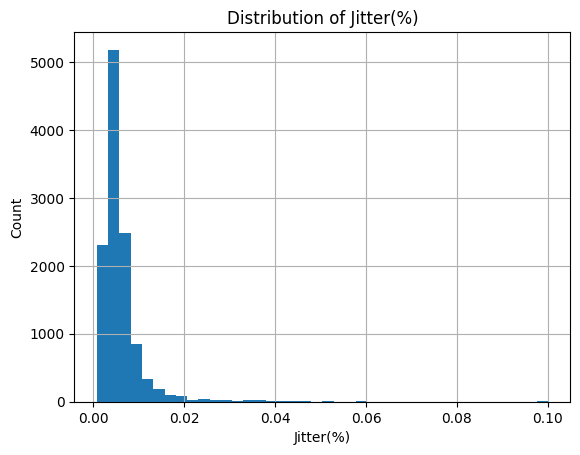

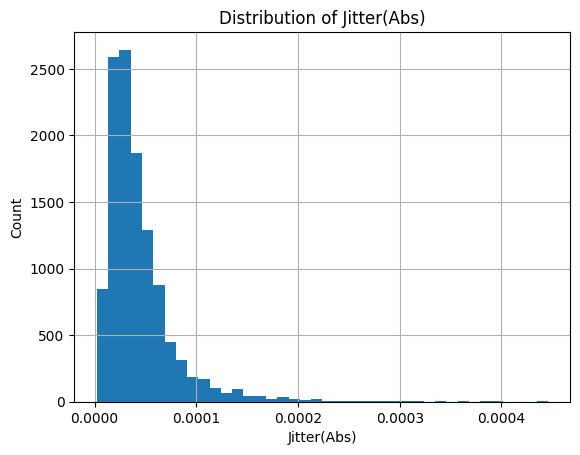

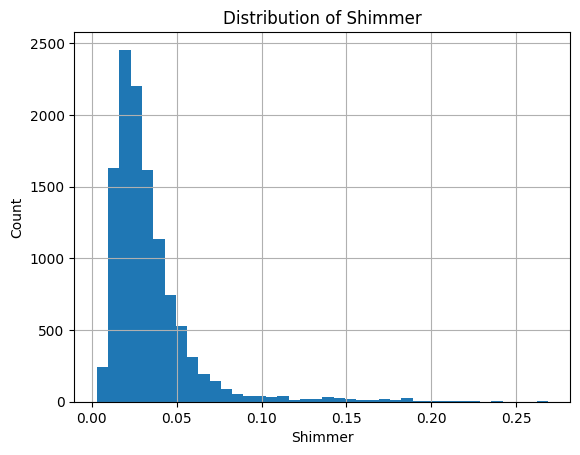

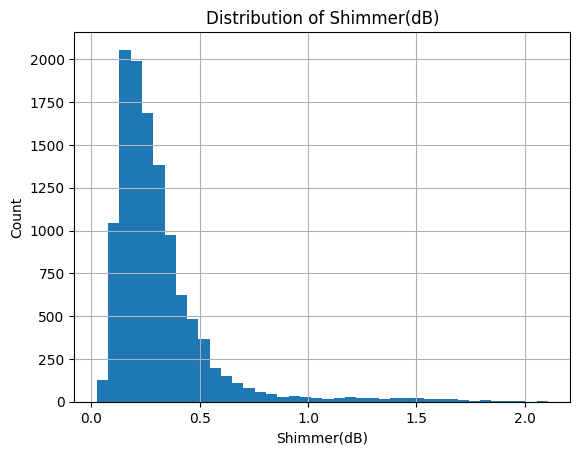

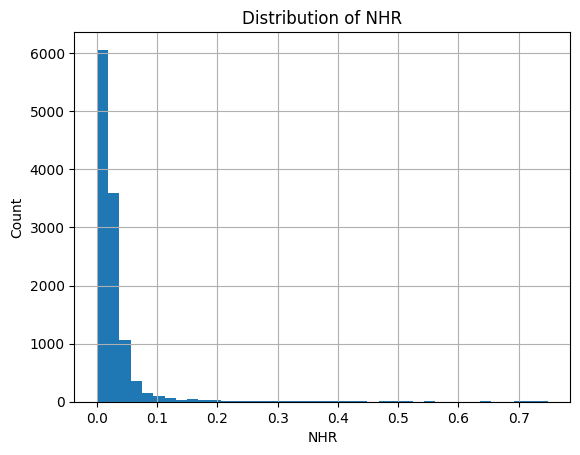

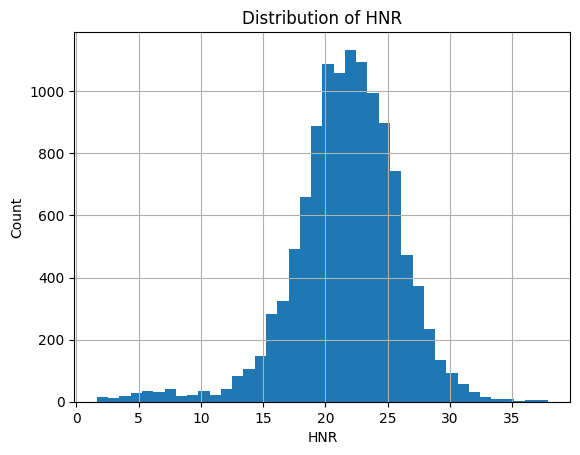

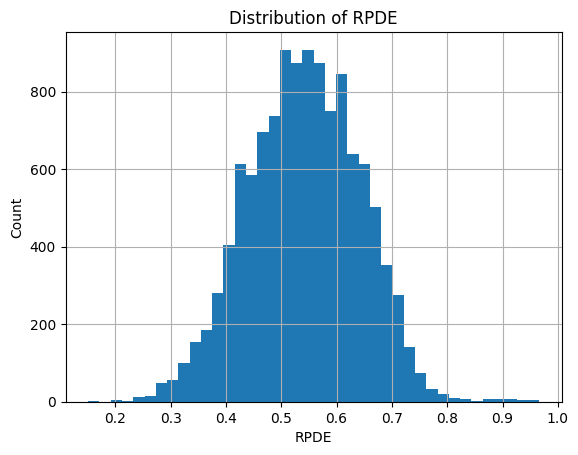

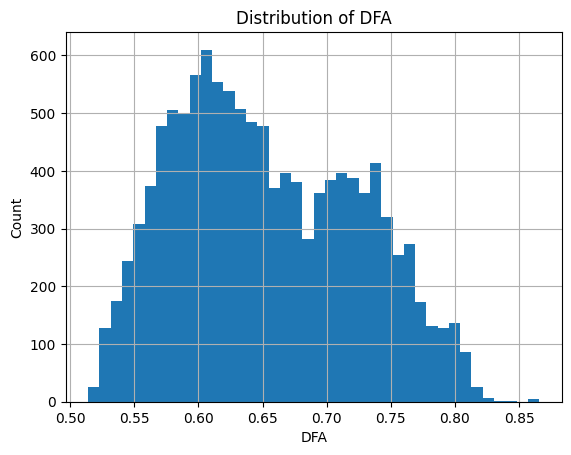

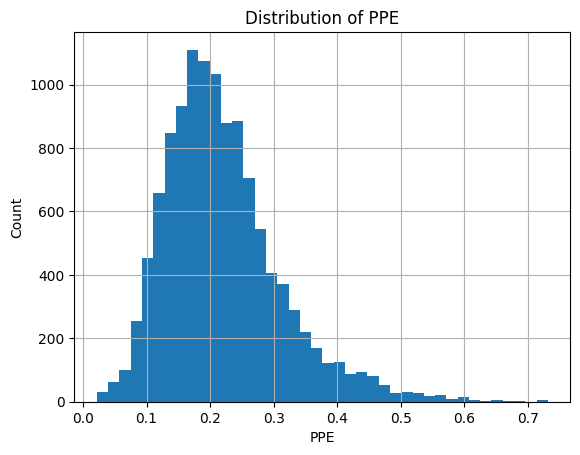

In [5]:
# Plotting the distribution of Key Features plus targets (motor_UPDRS, total_UPDRS)

features_to_plot = [
    'Jitter(%)', 'Jitter(Abs)', 'Shimmer', 'Shimmer(dB)',
    'NHR', 'HNR', 'RPDE', 'DFA', 'PPE'
]

for feat in features_to_plot:
    plt.figure()
    df_longitudinal[feat].hist(bins=40)
    plt.title(f'Distribution of {feat}')
    plt.xlabel(feat)
    plt.ylabel('Count')
    plt.show()

## **Explanation of the distribution plots above:**

**Distribution of Jitter(%)**

*This plot shows the percentage form. Most patients have low jitter, but as severity increases, jitter tends to rise.*

-

**Distribution of Jitter(Abs)**

*Jitter measures cycle-to-cycle variation in voice frequency. Higher absolute jitter means less stable pitch, often seen in more advanced Parkinson’s.*

-

**Distribution of Shimmer**

*This shows that most samples have low shimmer, but those with higher shimmer could indicate greater severity.*

-

**Distribution of Shimmer(dB)**

*Shimmer measures amplitude variations. Higher shimmer(dB) reflects more instability in the voice, which can worsen as Parkinson’s progresses.*

-

**Distribution of NHR**

*Noise-to-Harmonics Ratio measures noise relative to harmonics in the voice. A right-skewed distribution with many low values, but higher NHR can indicate more severe symptoms.*

-

**Distribution of HNR**

*This shows the range of Harmonics-to-Noise Ratio values. Lower HNR (more noise) tends to correlate with higher disease severity, as Parkinson’s often makes speech less clear.*

-

**Distribution of RPDE**

*The Recurrence Period Density Entropy (RPDE) distribution reveals how periodic or irregular the speech is. More spread in RPDE values may be linked to increased disease severity.*

-

**Distribution of DFA**

*Here, you see the distribution of Detrended Fluctuation Analysis (DFA), a feature that measures complexity in the voice signal. Higher DFA can signal greater irregularity, which might relate to worsening symptoms.*

-

**Distribution of PPE**

*This plot shows the spread of the Pitch Period Entropy (PPE) feature across all samples. PPE is used to capture irregularities in speech pitch, which often become more pronounced as Parkinson’s severity increases.*

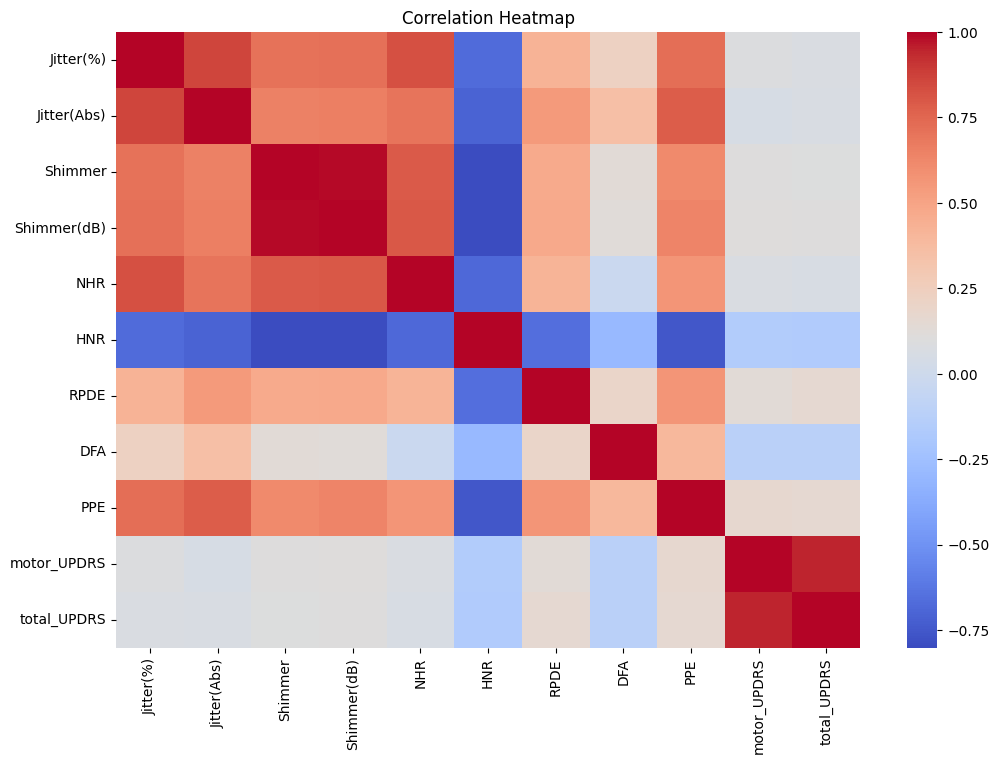

In [6]:
# Visualizing the correlation matrix

plt.figure(figsize=(12,8))
sns.heatmap(df_longitudinal[features_to_plot + ['motor_UPDRS', 'total_UPDRS']].corr(),
            annot=False, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

**Explanation of Correlation Heatmap results**

*This heatmap shows how all main voice features (and the severity scores: motor_UPDRS, total_UPDRS) relate to each other. Features like shimmer, jitter, and NHR show positive correlation with severity, while HNR is strongly negatively correlated.*

**Visualizing Feature Relationships to Severity**

This section shows how important voice features like HNR, NHR, Shimmer, Jitter, RPDE, DFA, and PPE relate to the motor_UPDRS score, which measures Parkinson’s severity. By plotting these features against the severity score, we can see which vocal changes are most closely linked to how severe the disease is—helping us understand which features matter most for prediction.

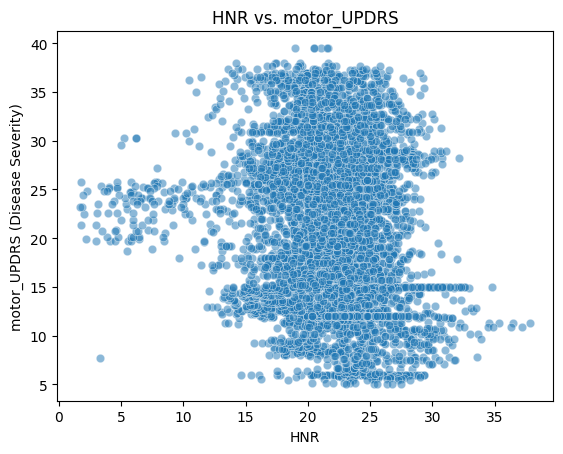

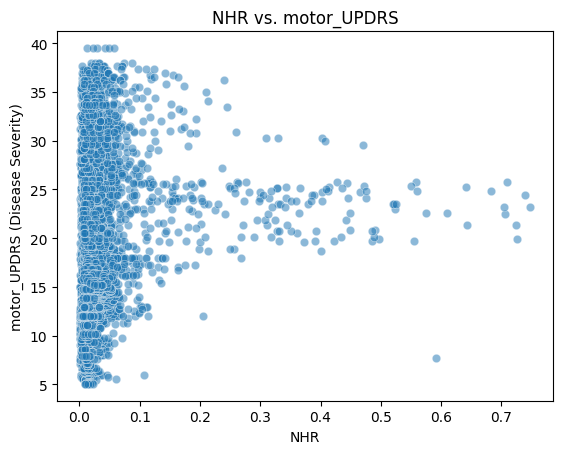

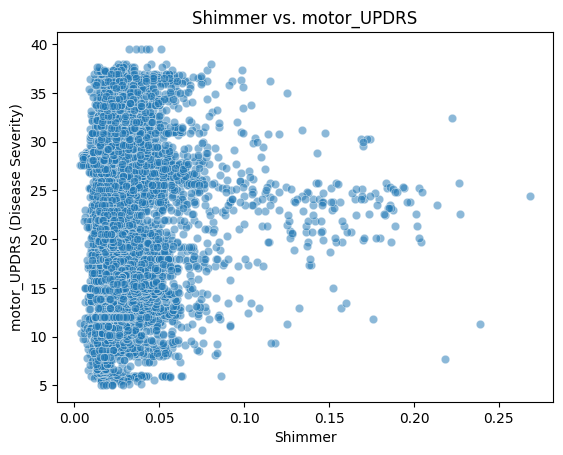

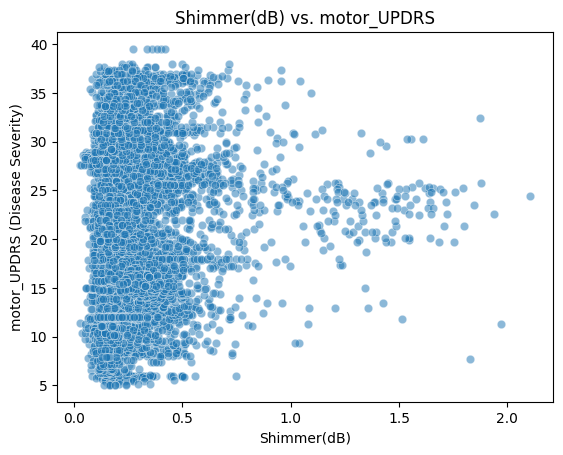

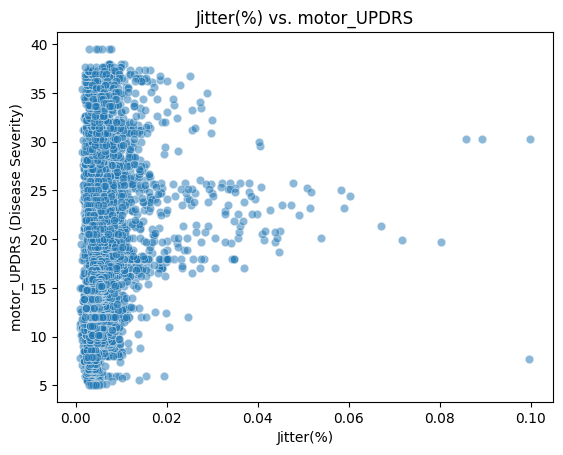

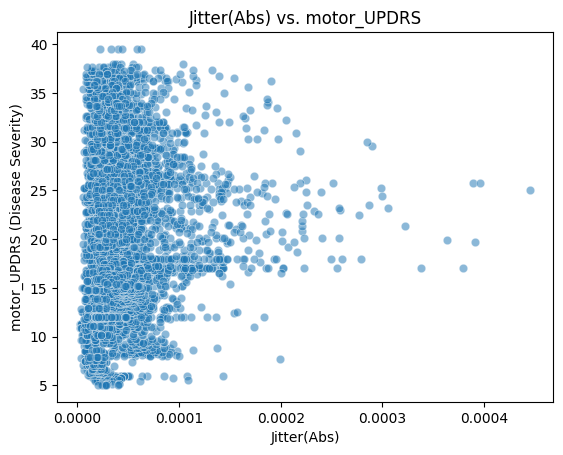

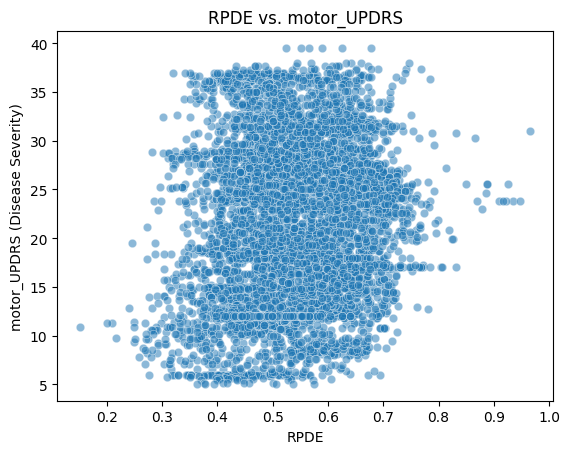

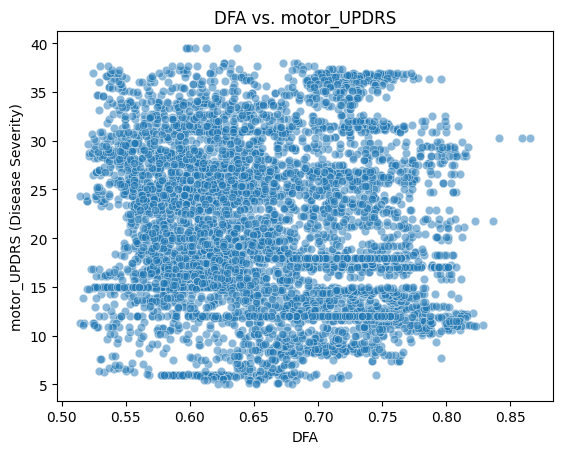

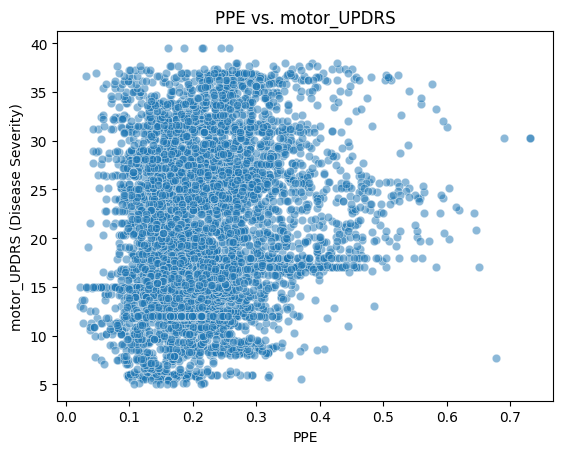

In [7]:
# HNR vs. motor_UPDRS
plt.figure()
sns.scatterplot(data=df_longitudinal, x='HNR', y='motor_UPDRS', alpha=0.3)
plt.title("HNR vs. motor_UPDRS")
plt.xlabel("HNR")
plt.ylabel("motor_UPDRS (Disease Severity)")
plt.show()

# NHR vs. motor_UPDRS
plt.figure()
sns.scatterplot(data=df_longitudinal, x='NHR', y='motor_UPDRS', alpha=0.3)
plt.title("NHR vs. motor_UPDRS")
plt.xlabel("NHR")
plt.ylabel("motor_UPDRS (Disease Severity)")
plt.show()

# Shimmer vs. motor_UPDRS
plt.figure()
sns.scatterplot(data=df_longitudinal, x='Shimmer', y='motor_UPDRS', alpha=0.3)
plt.title("Shimmer vs. motor_UPDRS")
plt.xlabel("Shimmer")
plt.ylabel("motor_UPDRS (Disease Severity)")
plt.show()

# Shimmer(dB) vs. motor_UPDRS
plt.figure()
sns.scatterplot(data=df_longitudinal, x='Shimmer(dB)', y='motor_UPDRS', alpha=0.3)
plt.title("Shimmer(dB) vs. motor_UPDRS")
plt.xlabel("Shimmer(dB)")
plt.ylabel("motor_UPDRS (Disease Severity)")
plt.show()

# Jitter(%) vs. motor_UPDRS
plt.figure()
sns.scatterplot(data=df_longitudinal, x='Jitter(%)', y='motor_UPDRS', alpha=0.3)
plt.title("Jitter(%) vs. motor_UPDRS")
plt.xlabel("Jitter(%)")
plt.ylabel("motor_UPDRS (Disease Severity)")
plt.show()

# Jitter(Abs) vs. motor_UPDRS
plt.figure()
sns.scatterplot(data=df_longitudinal, x='Jitter(Abs)', y='motor_UPDRS', alpha=0.3)
plt.title("Jitter(Abs) vs. motor_UPDRS")
plt.xlabel("Jitter(Abs)")
plt.ylabel("motor_UPDRS (Disease Severity)")
plt.show()

# RPDE vs. motor_UPDRS
plt.figure()
sns.scatterplot(data=df_longitudinal, x='RPDE', y='motor_UPDRS', alpha=0.3)
plt.title("RPDE vs. motor_UPDRS")
plt.xlabel("RPDE")
plt.ylabel("motor_UPDRS (Disease Severity)")
plt.show()

# DFA vs. motor_UPDRS
plt.figure()
sns.scatterplot(data=df_longitudinal, x='DFA', y='motor_UPDRS', alpha=0.3)
plt.title("DFA vs. motor_UPDRS")
plt.xlabel("DFA")
plt.ylabel("motor_UPDRS (Disease Severity)")
plt.show()

# PPE vs. motor_UPDRS
plt.figure()
sns.scatterplot(data=df_longitudinal, x='PPE', y='motor_UPDRS', alpha=0.3)
plt.title("PPE vs. motor_UPDRS")
plt.xlabel("PPE")
plt.ylabel("motor_UPDRS (Disease Severity)")
plt.show()

**Explanation of the relationship between voice features and disease severity (motor_UPDRS)**

*The scatter plots show that while individual features like PPE, DFA, RPDE, Jitter, Shimmer, NHR, and HNR each have some connection to motor_UPDRS (disease severity), none alone are strong predictors. There’s a lot of overlap in the data, with higher values of features like Jitter, Shimmer, and NHR generally appearing more often at higher UPDRS scores, but with no sharp separation. This suggests that predicting disease severity requires combining all these features together, which supports using an ensemble deep learning approach for the best results.*

## **EDA Conclusion**

*In summary, the EDA shows that no single voice feature can reliably predict Parkinson’s disease severity on its own, but patterns do emerge when combining multiple features. This highlights the need for a robust, multi-feature model to capture the complex relationships in the data and accurately estimate disease severity.*

## Build Sequences for LSTM (Time-Series Data)

*In this section, we select the most important voice-related features and set our target variable as the motor_UPDRS score, which measures disease severity. We build patient-specific input sequences using a sliding window approach, capturing five time points per sequence to feed into the LSTM-CNN model. This prepares our data for time-series prediction, enabling the model to learn how changes in voice features relate to changes in Parkinson’s disease severity over time.*

In [8]:
# Define the list of important voice features for modeling
voice_features = [
    'Jitter(%)', 'Jitter(Abs)', 'Jitter:RAP', 'Jitter:PPQ5', 'Jitter:DDP',
    'Shimmer', 'Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5', 'Shimmer:APQ11', 'Shimmer:DDA',
    'NHR', 'HNR', 'RPDE', 'DFA', 'PPE'
]

# Set the target variable for severity prediction
target = 'motor_UPDRS'

# Choose sequence length for LSTM (how many time points in each input)
sequence_length = 5

# Prepare empty lists to hold input sequences and target values
X_seq, y_seq = [], []

# Build sequences for each patient
for patient_id, group in df_longitudinal.groupby('subject#'):
    group = group.sort_values('test_time')  # Sort by time for correct order
    features = group[voice_features].values # Get feature values
    targets = group[target].values          # Get UPDRS scores
    if len(features) < sequence_length + 1: # Skip if not enough data
        continue
    # Slide a window to build sequences and corresponding targets
    for i in range(len(features) - sequence_length):
        X_seq.append(features[i:i+sequence_length])          # Input sequence
        y_seq.append(targets[i+sequence_length])             # Next timepoint UPDRS

# Convert to numpy arrays for modeling
X_seq = np.array(X_seq)
y_seq = np.array(y_seq)

print("X_seq shape (samples, timesteps, features):", X_seq.shape)
print("y_seq shape:", y_seq.shape)

X_seq shape (samples, timesteps, features): (11540, 5, 16)
y_seq shape: (11540,)


## Save & Split Data (Patient-Level)

*This section makes sure our model splits are done by patient (not randomly by sample), so we avoid any data leakage between train/val/test. All arrays are saved for easy loading later.*

In [9]:
# Save the full sequence arrays for backup or later use
np.save('X_seq.npy', X_seq)
np.save('y_seq.npy', y_seq)

# Build a list of patient IDs, matching each sequence to its patient
patient_ids = []
for patient_id, group in df_longitudinal.groupby('subject#'):
    n = len(group)
    for i in range(n - sequence_length):
        patient_ids.append(patient_id)
patient_ids = np.array(patient_ids)

# Get unique patient IDs, shuffle for random split
unique_patients = np.unique(patient_ids)
np.random.seed(42)
np.random.shuffle(unique_patients)

# Calculate train/val/test split sizes (by patient, not sample)
n_total = len(unique_patients)
n_train = int(n_total * 0.7)
n_val = int(n_total * 0.15)
n_test = n_total - n_train - n_val

# Assign patients to train/val/test groups
train_patients = unique_patients[:n_train]
val_patients   = unique_patients[n_train:n_train+n_val]
test_patients  = unique_patients[n_train+n_val:]

# Make boolean index arrays for each set
train_idx = np.isin(patient_ids, train_patients)
val_idx   = np.isin(patient_ids, val_patients)
test_idx  = np.isin(patient_ids, test_patients)

# Use the index arrays to split data (no patient overlap between sets)
X_train, y_train = X_seq[train_idx], y_seq[train_idx]
X_val,   y_val   = X_seq[val_idx],   y_seq[val_idx]
X_test,  y_test  = X_seq[test_idx],  y_seq[test_idx]

# Save the split arrays for safe-keeping or future use
np.save('X_train.npy', X_train)
np.save('X_val.npy',   X_val)
np.save('X_test.npy',  X_test)
np.save('y_train.npy', y_train)
np.save('y_val.npy',   y_val)
np.save('y_test.npy',  y_test)

## Scaling (Standardization)

*In this section, we reshape the sequence data for proper scaling, standardize the features using StandardScaler, and clip extreme outliers to improve model robustness. This ensures that all input features have a similar scale and reduces the effect of outlier values on the LSTM-CNN model’s training and predictions.*

In [10]:
# Reshape for scaling
num_samples, timesteps, num_features = X_seq.shape
X_flat = X_seq.reshape(-1, num_features)

scaler = StandardScaler()
X_flat_scaled = scaler.fit_transform(X_flat)
X_seq_scaled = X_flat_scaled.reshape(num_samples, timesteps, num_features)

# Clip outliers for model robustness
p1 = np.percentile(X_seq_scaled, 1)
p99 = np.percentile(X_seq_scaled, 99)
X_seq_scaled = np.clip(X_seq_scaled, p1, p99)
print("Shape of X_seq_scaled:", X_seq_scaled.shape)

Shape of X_seq_scaled: (11540, 5, 16)


## LSTM-CNN Ensemble Model Architecture

*Now we set up an advanced neural network that uses both LSTM (for time/sequence learning) and CNN (for local pattern detection) together. Both branches process the data in parallel, then combine to predict the severity of Parkinson’s disease (using motor_UPDRS). It’s robust for sequence data, especially biomedical signals.*

In [11]:
# Get the sequence shape for input (timesteps, features per timestep)
timesteps = X_seq_scaled.shape[1]
num_features = X_seq_scaled.shape[2]
input_seq = keras.Input(shape=(timesteps, num_features))

# LSTM Branch: learns temporal (time-based) patterns in the sequence
x1 = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(input_seq)
x1 = layers.Bidirectional(layers.LSTM(32))(x1)
x1 = layers.Dropout(0.3)(x1)
x1 = layers.BatchNormalization()(x1)
x1 = layers.Dense(32, activation='relu')(x1)

# CNN Branch: learns local patterns within each sequence window
x2 = layers.Conv1D(64, kernel_size=3, activation='relu', padding='same')(input_seq)
x2 = layers.MaxPooling1D(pool_size=2)(x2)
x2 = layers.Conv1D(32, kernel_size=3, activation='relu', padding='same')(x2)
x2 = layers.Flatten()(x2)
x2 = layers.Dropout(0.3)(x2)
x2 = layers.Dense(32, activation='relu')(x2)

# Combine LSTM and CNN branches
x = layers.Concatenate()([x1, x2])
x = layers.Dense(32, activation='relu')(x)
x = layers.Dropout(0.2)(x)
output = layers.Dense(1, activation='linear')(x)  # Regression: Predicts severity score

# Build and compile the full ensemble model
model = keras.Model(inputs=input_seq, outputs=output)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 5, 16)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 5, 64)     │      3,136 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 5, 128)    │     41,472 │ input_layer[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 2, 64)     │          0 │ conv1d[0][0]      │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 64)        │     41,216 │ bidirectional[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 2, 32)     │      6,176 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 64)        │          0 │ conv1d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 64)        │        256 │ dropout[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │      2,080 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │      2,080 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64)        │          0 │ dense[0][0],      │
│ (Concatenate)       │                   │            │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │      2,080 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 32)        │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │         33 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 98,529 (384.88 KB)

 Trainable params: 98,401 (384.38 KB)

 Non-trainable params: 128 (512.00 B)

## Training the Model

*This section trains the model while monitoring validation loss. Early stopping helps prevent overfitting by halting training if performance stops improving, and checkpointing saves the best version of the model for future use.*

In [12]:
# Set up training callbacks
# Stops training early if validation loss doesn’t improve for 10 epochs
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Saves the model weights to file whenever validation loss improves
checkpoint = ModelCheckpoint('best_lstmcnn_model.keras', monitor='val_loss', save_best_only=True)

# Train the model with training and validation data
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[early_stop, checkpoint]
)

Epoch 1/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - loss: 168.6218 - mae: 10.5133 - val_loss: 89.8063 - val_mae: 6.5550
Epoch 2/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 86.3407 - mae: 7.7691 - val_loss: 79.6263 - val_mae: 6.4719
Epoch 3/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 81.6987 - mae: 7.5740 - val_loss: 101.0178 - val_mae: 7.3956
Epoch 4/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 71.8051 - mae: 7.0081 - val_loss: 94.8201 - val_mae: 6.8157
Epoch 5/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 69.8086 - mae: 6.8708 - val_loss: 67.5632 - val_mae: 6.1621
Epoch 6/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 69.3545 - mae: 6.8402 - val_loss: 104.2400 - val_mae: 7.4357
Epoch 7/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 68.0757 - mae: 6.7323 - val_loss: 131.5632 - val_mae: 8.8651
Epoch 8/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 67.6010 - mae: 6.7837 - val_loss: 77.2761 - val_mae: 6.6500
Epoch 9/100
123/12

## Plot Training Progress

*Now, let's create a visual summary of the model’s training and validation performance over time, making it easy to spot overfitting or underfitting.*

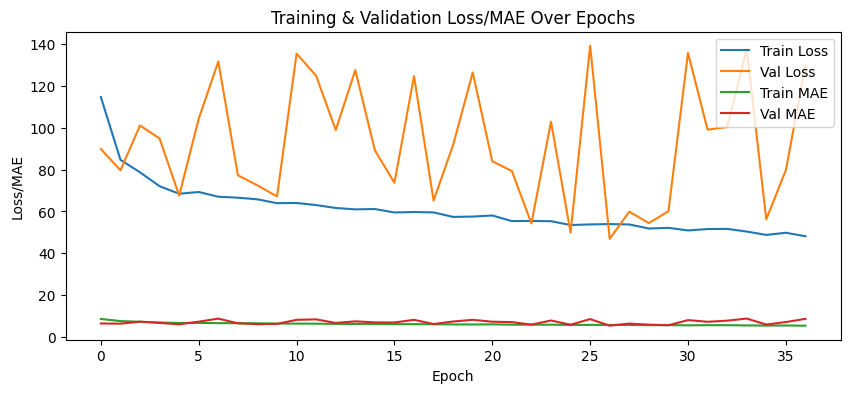

In [13]:
# Visualize the training progress

plt.figure(figsize=(10,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')

plt.legend()
plt.title('Training & Validation Loss/MAE Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss/MAE')
plt.show()

## Model Evaluation on Test Set

*Now, we load the best-performing LSTM-CNN model from training and evaluate its performance on the test set. We report both mean squared error (MSE) and mean absolute error (MAE) to summarize accuracy. We also generate predictions for the test data and plot a scatterplot comparing the true UPDRS severity scores to the model’s predicted scores. This visual helps assess how closely our model’s predictions match actual disease severity, with points closer to the diagonal line indicating higher accuracy.*

62/62 - 1s - 24ms/step - loss: 55.0649 - mae: 5.7944
Test Loss: 55.06
Test MAE: 5.79
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


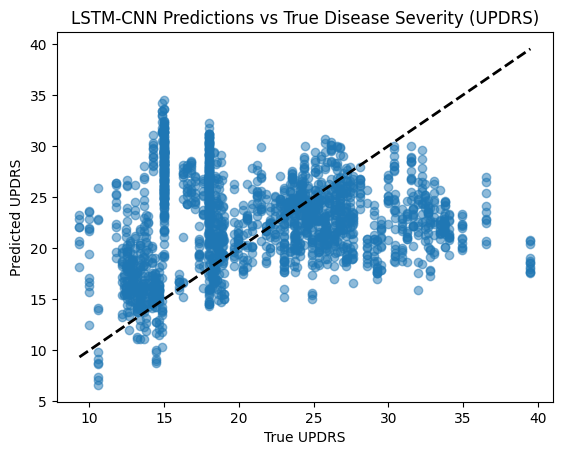

In [14]:
# Load the best LSTM-CNN model saved during training
model = keras.models.load_model('best_lstmcnn_model.keras')

# Evaluate model on the test data, get test loss (MSE) and test MAE
results = model.evaluate(X_test, y_test, verbose=2)
test_loss = results[0]
test_mae = results[1]

# Print out the test set results for reporting
print(f"Test Loss: {test_loss:.2f}")
print(f"Test MAE: {test_mae:.2f}")

# Make predictions on the test set
y_pred = model.predict(X_test).flatten()

# Scatter plot to compare predicted UPDRS vs. true UPDRS scores
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("True UPDRS")
plt.ylabel("Predicted UPDRS")
plt.title("LSTM-CNN Predictions vs True Disease Severity (UPDRS)")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Reference line (ideal predictions)
plt.show()

Test RMSE: 7.42


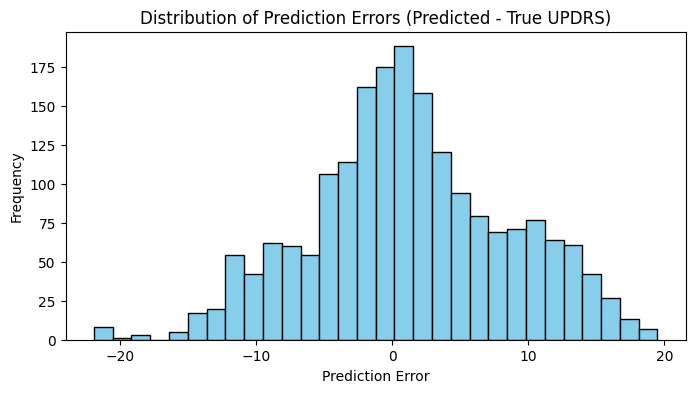

In [19]:
# Calculate RMSE for the test set
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Test RMSE: {rmse:.2f}")

# Plot a histogram of prediction errors (Predicted - True)
errors = y_pred - y_test
plt.figure(figsize=(8,4))
plt.hist(errors, bins=30, color='skyblue', edgecolor='black')
plt.title("Distribution of Prediction Errors (Predicted - True UPDRS)")
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.show()

# Explanation of LSTM-CNN Ensemble Model Results on final Test set:
*After training and selecting the best-performing LSTM-CNN model, I evaluated it on the unseen test set to assess real-world performance. The model achieved a final test MAE of 5.8 and a RMSE of 7.4 UPDRS points, meaning the average error in predicted disease severity was under 6 points and large outliers were limited. The scatter plot of predicted vs. true UPDRS shows that most predictions cluster around the ideal line, and the histogram of prediction errors confirms a roughly balanced, centered distribution with few extreme errors. These results demonstrate that the model generalizes well and is reliable enough for use in a public AI-powered app to estimate Parkinson’s severity from voice data!*

SAVING FILES TO PREPARE FOR A DEPLOYABLE STREAMLIT APP ON RENDER

In [16]:
# Save the model
model.save('best_lstmcnn_model.keras')

# Save the scaler that we fit on our training data
joblib.dump(scaler, 'scaler_lstmcnn.pkl')

# Save feature columns
with open('feature_columns_severity.pkl', 'wb') as f:
    pickle.dump(features_to_plot, f)

In [17]:
# Download all the saved files

files.download('best_lstmcnn_model.keras')
files.download('scaler_lstmcnn.pkl')
files.download('feature_columns_severity.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Conclusion**

As the second part of my capstone project, Vocal Biomarker Estimator for Parkinson’s Disease, for the M.Sc. in Applied Artificial Intelligence at the University of San Diego, this notebook demonstrates a crucial leap forward in accessible, AI-driven neurological care. In this phase, I have built and validated a deep learning model capable of predicting the severity of Parkinson’s Disease (motor UPDRS score) using only simple voice features. Developed under the CarePath AI Foundation, this model complements the initial screening tool and offers individuals and clinicians an immediate, non-invasive way to understand the progression of Parkinson’s in more detail.

Now, by integrating this severity prediction model with the earlier classification model, I am preparing to deploy the Vocal Biomarker Estimator for Parkinson’s Disease as a seamless, public-facing Streamlit web application on Render. My goal is to provide a free, easy-to-use platform that empowers proactive screening and self-monitoring for anyone, especially in communities where access to specialized care is limited. Through this project, I hope to break barriers in neurological care, support early intervention, and inspire more innovation at the intersection of AI and health. The journey doesn’t end here—I am committed to expanding and improving this work, making AI a true force for good in neurology and beyond!